# **Titanic survival prediction**
___

⚙ **Setup**

## 📃**The Problem** ##
This project is about the titanic ship wreck, that happened on February 09, 1910.

The data contains $891$ records of passengers who were aboard. Each column is a variable about a passenger. The following were variables were recorded for each passenger.

|    |  PassengerId | Description
|----|--------------|------------------
| 1  |  Survived    | If the passenger survived the harvoc or not `1: Survived`, `0: Did not survive`.
| 2  |  Pclass      | The Pclass of the passenger `1`, `2` or `3`.
| 3  |  Name        | The passenger's name
| 4  |  Sex         | The passenger's sex
| 5  |  Age         | The passenger's age.
| 6  |  SibSp       | Nimber of siblings or spose the passenger has aboard.
| 7  |  Parch       | Passenger's porch
| 8  |  Ticket      | Ticket ID
| 9  |  Fare        | Fare
| 10 |  Cabin       |
| 11 |  Embark      | 

In this project, we want to use the dataset to predict to predict the attributes which determines the survival of passengers.

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn

import warnings


parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from _custom_func import extract_data


sns.set_style("darkgrid")
pd.set_option("display.max_columns", None)
sklearn.set_config(display="diagram")


warnings.filterwarnings("ignore")

print("\n💯 😊 Setup successfully loaded to memory.")


💯 😊 Setup successfully loaded to memory.


## 📝 **Get the data**

The data is the famouus titanic dataset, downloaded from 👉 [here](https://kagggke.com/).

In [3]:
try:
    extract_data("../datasets/Titanic-Dataset.zip")
    df = pd.read_csv("./data/Titanic-Dataset.csv")
    print("\nData loaded successfully . . .")
except Exception as e:
    print("\033[031mError in loading data . . .\033[0m\n", e)


Data loaded successfully . . .


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 🔎 **Explore the data**

Exploring the data through summary statistics and visualizations

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The `Age` and `Cabin` attributes were missinng for some passengers.

**Get summary statistics for the neccessary attrributes.**

In [25]:
df_num = df[["Pclass", "Age", "SibSp", "Fare"]]
df_num.describe()

,Pclass,Age,SibSp,Fare
count,891.000000,714.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,32.204208
std,0.836071,14.526497,1.102743,49.693429
min,1.000000,0.420000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,31.000000
max,3.000000,80.000000,8.000000,512.329200


The median age is $28$, meaning that half of the total passengers have ages that are less than or equal to $28$. The maximum age is $80$, meaning that there are children, youtg and adults in the ship. The mean age is $29$, that is most passengers are youths. The age attribute was not copletely recorded.

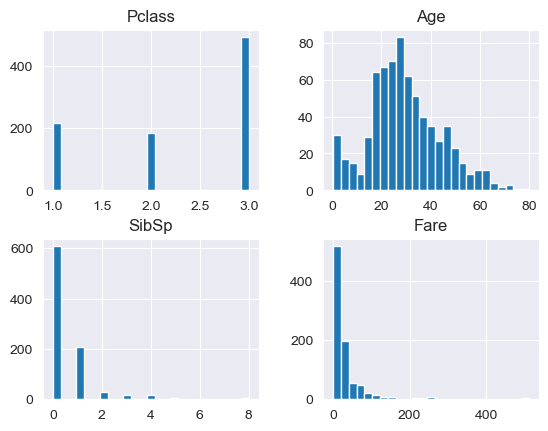

In [26]:
ax = df_num.hist(bins=25)
plt.show()

The `Age` attribute spread more than the other numerical attributes. There are more passengers in the `3` Pclass.

AttributeError: Rectangle.set() got an unexpected keyword argument 'bw'

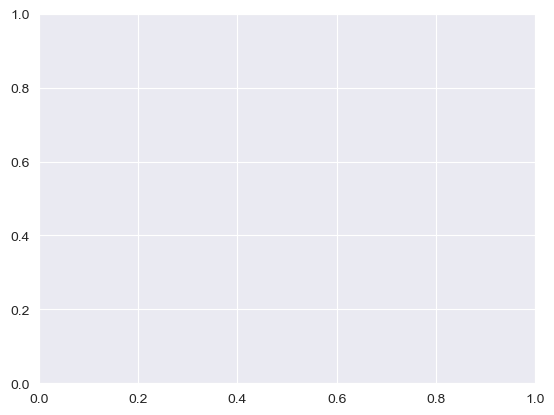

In [30]:
df.Embarked.value_counts().plot.barh()